In [27]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('/home/cocoza4/workspace/absorouteio/asr-face-recognition/src')

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from skimage import transform as trans
import matplotlib.pyplot as plt

import align
from align import detect_face

tf.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'2.1.0'

In [2]:
gpu_memory_fraction = 1.

In [3]:
with tf.Graph().as_default():
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)
    sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
    with sess.as_default():
        pnet, rnet, onet = detect_face.create_mtcnn(sess, None)

W0422 01:37:13.334377 139802666587968 deprecation.py:506] From /home/cocoza4/ENVs/ar-models/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1635: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0422 01:37:13.580901 139802666587968 deprecation.py:323] From /home/cocoza4/workspace/absorouteio/asr-face-recognition/src/align/detect_face.py:213: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [4]:
minsize = 20 # minimum size of face
threshold = [ 0.6, 0.7, 0.7 ]  # three steps's threshold
factor = 0.709 # scale factor

w = 112
h = 112

In [5]:
# f = '/home/cocoza4/datasets/cfp-dataset/Data/Images/001/frontal/03.jpg'
# f = '/home/cocoza4/datasets/cfp-dataset/Data/Images/002/frontal/07.jpg'
# f = '/home/cocoza4/workspace/object-detection/test_images/two_people_small.png'
f = '/home/cocoza4/Pictures/asian-faces.jpg'
img = np.asarray(Image.open(f))
img.shape

(400, 312, 3)

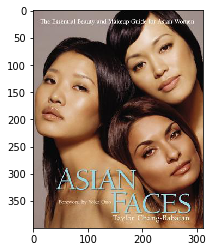

In [6]:
plt.imshow(img)

In [7]:
bounding_boxes, points = detect_face.detect_face(img, minsize, pnet, rnet, onet, threshold, factor)
bounding_boxes

array([[  7.0976363 ,  79.81575993, 120.88168588, 230.03487176,
          0.99998689],
       [175.58746927, 189.83005044, 301.11162747, 322.57386065,
          0.99994719],
       [155.09189647,  16.45544204, 300.26075032, 175.85684144,
          0.99970585]])

In [8]:
points

array([[ 33.246548, 215.81084 , 192.82616 ],
       [ 85.43655 , 262.42026 , 242.26297 ],
       [ 38.896366, 260.98224 , 233.48232 ],
       [ 18.316263, 252.93282 , 233.76079 ],
       [ 57.520992, 290.24698 , 270.60574 ],
       [130.8868  , 258.6632  , 104.608475],
       [143.16872 , 228.16164 ,  67.83826 ],
       [156.59123 , 266.68765 , 114.0733  ],
       [188.19824 , 303.32788 , 150.83641 ],
       [198.43227 , 278.7655  , 119.914925]], dtype=float32)

In [10]:
det = bounding_boxes[:,0:4]
det_arr = []
img_size = np.asarray(img.shape)[0:2]
img_size

array([400, 312])

In [47]:
det_arr.append(np.squeeze(det))

In [11]:
det_arr = np.squeeze(det)
det_arr

array([[  7.0976363 ,  79.81575993, 120.88168588, 230.03487176],
       [175.58746927, 189.83005044, 301.11162747, 322.57386065],
       [155.09189647,  16.45544204, 300.26075032, 175.85684144]])

In [57]:
bounding_box_size = (det[:,2]-det[:,0])*(det[:,3]-det[:,1])
img_center = img_size / 2
offsets = np.vstack([ (det[:,0]+det[:,2])/2-img_center[1], (det[:,1]+det[:,3])/2-img_center[0] ])
offset_dist_squared = np.sum(np.power(offsets,2.0),0)
index = np.argmax(bounding_box_size-offset_dist_squared*2.0) # some extra weight on the centering
det_arr.append(det[index,:])

In [16]:
margin = 0

In [31]:
landmarks = points[:, 2].reshape( (2,5) ).T
landmarks

array([[192.82616 , 104.608475],
       [242.26297 ,  67.83826 ],
       [233.48232 , 114.0733  ],
       [233.76079 , 150.83641 ],
       [270.60574 , 119.914925]], dtype=float32)

In [32]:
for i, det in enumerate(det_arr[1:]):
    det = np.squeeze(det)
    print(det)
    bb = np.zeros(4, dtype=np.int32)
    bb[0] = np.maximum(det[0]-margin/2, 0)
    bb[1] = np.maximum(det[1]-margin/2, 0)
    bb[2] = np.minimum(det[2]+margin/2, img_size[1])
    bb[3] = np.minimum(det[3]+margin/2, img_size[0])
    cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
    scaled = Image.fromarray(cropped).resize((w, h))

[175.58746927 189.83005044 301.11162747 322.57386065]
[155.09189647  16.45544204 300.26075032 175.85684144]


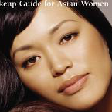

In [33]:
scaled

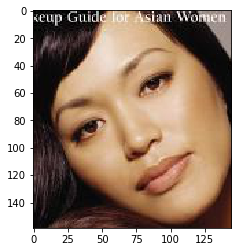

In [34]:
plt.imshow(cropped)

In [35]:
src = np.array([
  [30.2946, 51.6963],
  [65.5318, 51.5014],
  [48.0252, 71.7366],
  [33.5493, 92.3655],
  [62.7299, 92.2041] ], dtype=np.float32 )

src[:,0] += 8.0

In [36]:
dst = landmarks.astype(np.float32)

tform = trans.SimilarityTransform()
tform.estimate(dst, src)
M = tform.params[0:2,:]
M

array([[  0.51218432,  -0.37265423, -22.59202435],
       [  0.37265423,   0.51218432, -72.60441077]])

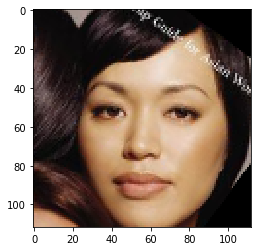

In [37]:
warped = cv2.warpAffine(img, M, (112, 112), borderValue = 0.0)
plt.imshow(warped)